In [1]:
import os
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

### Initialise the environment

In [2]:
p1 = 0.80 # true expected payoff for arm 1
p2 = 0.50 # true expected payoff for arm 2

arms = [p1, p2]

### Initialise the agent

In [3]:
a = np.array([1, 4])
np.array(a >= a.max()).astype(int)

array([0, 1])

In [4]:
def policy(q_values, temp=None, type='softmax'):

    if temp:
        t = temp
    else:
        t = 1
    if type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    else:
        return np.array(q_values >= q_values.max()).astype(int)

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

gamma   = 0.9
gittins = np.genfromtxt('../gittins200_gamma09.csv', delimiter=',') # load gittins indices
gittins = gittins[1:, 1:] # remove (0, .) and (., 0) priors

# initial belief state
M = np.array([
    [1, 1],
    [1, 1]
], dtype=int)

temp = 1 # inverse temperature for softmax

### Run the model-free agent

In [5]:
np.random.seed(1234)

num_episodes = 180
for ep in range(num_episodes):
    Q  = np.array([gittins[M[0, 0], M[0, 1]], gittins[M[1, 0], M[1, 1]]])
    # a = np.argmax(Q)
    ps = policy(Q, temp=temp)
    a  = np.random.choice([0, 1], p=ps)
    r  = np.random.choice([0, 1], p=(1-arms[a], arms[a]))
    M  = belief_update(M, a, r)

### Plot the resulting belief

Text(0.5, 1.0, '$\\mathbb{E}[p\\mid b]$')

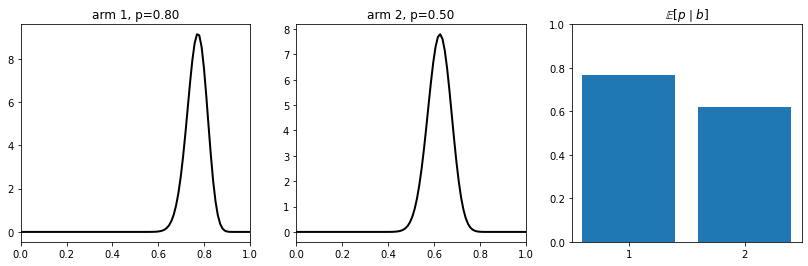

In [6]:
plt.figure(figsize=(14, 4))

x = np.linspace(0, 1, 100)
plt.subplot(1, 3, 1)
a, b = M[0, 0], M[0, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 1, p=%.2f'%arms[0])
plt.subplot(1, 3, 2)
a, b = M[1, 0], M[1, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 2, p=%.2f'%arms[1])
plt.subplot(1, 3, 3)
plt.bar([1, 2], [M[0, 0]/np.sum(M[0, :]), M[1, 0]/np.sum(M[1, :])])
plt.xticks([1, 2], [1, 2])
plt.ylim(0,1)
plt.title(r'$\mathbb{E}[p\mid b]$')

In [7]:
M

array([[72, 22],
       [56, 34]])

### Construct belief tree

In [8]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0, 0)] = b
    tree[0][(1, 1)] = b

    for hi in range(1, h):
        c = 0
        for k, v in tree[hi-1].items():
            
            prev_c = k[-1]
            prev_a = k[0]
            
            for r in [0, 1]:
                
                b1 = belief_update(v, prev_a, r)
                tree[hi][(prev_a, a, prev_c, c)] = b1
                c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
    v(ba^*)-v(b) =& \mathbb{E}_{b'\sim p(b'\mid b, a^*)}\Big[\sum_a \big(\pi(a\mid b')-\pi(a\mid b)\big)q(b',a) \\
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[r(b',a) - r(b,a)\big]  \\ 
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[\gamma \sum_{b''}p(b''\mid b', a)v(b'') - \gamma \sum_{g'}p(g'\mid b, a)v(g') \big] \Big] 
\end{align*}
$$

where $ba^*$ is a belief that results from choosing action $a^*$ from belief $b$, the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [74]:
def evb(b, a, b_primes: list):

    gain_sum = 0
    rew_sum  = 0
    nxt_sum  = 0

    # print('\n')
    # print('b: ', b)
    # print('a: ', a)
    # print('b_primes: ', b_primes)

    q        = np.array([gittins[b[0, 0], b[0, 1]], gittins[b[1, 0], b[1, 1]]]) # q values before update
    probs    = policy(q, temp=5) # policy before update
    tmp_rew  = np.array([b[0, 0]/np.sum(b[0, :]), b[1, 0]/np.sum(b[1, :])])

    # print('q: ', q)
    # print('probs: ', probs)
    # print('tmp_rew: ', tmp_rew)

    b_prime_arm0_rew0 = belief_update(b, 0, 0)
    b_prime_arm0_rew1 = belief_update(b, 0, 1)
    b_prime_arm1_rew0 = belief_update(b, 1, 0)
    b_prime_arm1_rew1 = belief_update(b, 1, 1)

    q_prime_arm0_rew0 = np.array([gittins[b_prime_arm0_rew0[0, 0], b_prime_arm0_rew0[0, 1]], gittins[b_prime_arm0_rew0[1, 0], b_prime_arm0_rew0[1, 1]]])
    q_prime_arm0_rew1 = np.array([gittins[b_prime_arm0_rew1[0, 0], b_prime_arm0_rew1[0, 1]], gittins[b_prime_arm0_rew1[1, 0], b_prime_arm0_rew1[1, 1]]])
    q_prime_arm1_rew0 = np.array([gittins[b_prime_arm1_rew0[0, 0], b_prime_arm1_rew0[0, 1]], gittins[b_prime_arm1_rew0[1, 0], b_prime_arm1_rew0[1, 1]]])
    q_prime_arm1_rew1 = np.array([gittins[b_prime_arm1_rew1[0, 0], b_prime_arm1_rew1[0, 1]], gittins[b_prime_arm1_rew1[1, 0], b_prime_arm1_rew1[1, 1]]])

    v_prime_arm0 = (b[0, 0]/np.sum(b[0, :]))*np.dot(policy(q_prime_arm0_rew1, temp=5), q_prime_arm0_rew1) + (b[0, 1]/np.sum(b[0, :]))*np.dot(policy(q_prime_arm0_rew0, temp=5), q_prime_arm0_rew0)
    v_prime_arm1 = (b[1, 0]/np.sum(b[1, :]))*np.dot(policy(q_prime_arm1_rew1, temp=5), q_prime_arm1_rew1) + (b[1, 1]/np.sum(b[1, :]))*np.dot(policy(q_prime_arm1_rew0, temp=5), q_prime_arm1_rew0)

    v_prime = np.dot(probs, np.array([v_prime_arm0, v_prime_arm1]))
    # print('v_prime: ', v_prime)

    for b_prime in b_primes:
        q_prime     = np.array([gittins[b_prime[0, 0], b_prime[0, 1]], gittins[b_prime[1, 0], b_prime[1, 1]]]) # q values after update
        probs_prime = policy(q_prime, temp=5) # policy after update

        gain = np.dot(probs_prime - probs, q_prime) # gain
        
        tmp_rew_prime = np.array([b_prime[0, 0]/np.sum(b_prime[0, :]), b_prime[1, 0]/np.sum(b_prime[1, :])])
        rew = np.dot(probs, (tmp_rew_prime - tmp_rew))

        # print('b_prime: ', b_prime)
        # print('q_prime: ', q_prime)
        # print('probs_prime: ', probs_prime)
        # print('gain: ', gain)
        # print('tmp_rew_prime: ', tmp_rew_prime)
        # print('rew:, ', rew)

        b_prime_prime_arm0_rew0 = belief_update(b_prime, 0, 0)
        b_prime_prime_arm0_rew1 = belief_update(b_prime, 0, 1)
        b_prime_prime_arm1_rew0 = belief_update(b_prime, 1, 0)
        b_prime_prime_arm1_rew1 = belief_update(b_prime, 1, 1)

        q_prime_prime_arm0_rew0 = np.array([gittins[b_prime_prime_arm0_rew0[0, 0], b_prime_prime_arm0_rew0[0, 1]], gittins[b_prime_prime_arm0_rew0[1, 0], b_prime_prime_arm0_rew0[1, 1]]])
        q_prime_prime_arm0_rew1 = np.array([gittins[b_prime_prime_arm0_rew1[0, 0], b_prime_prime_arm0_rew1[0, 1]], gittins[b_prime_prime_arm0_rew1[1, 0], b_prime_prime_arm0_rew1[1, 1]]])
        q_prime_prime_arm1_rew0 = np.array([gittins[b_prime_prime_arm1_rew0[0, 0], b_prime_prime_arm1_rew0[0, 1]], gittins[b_prime_prime_arm1_rew0[1, 0], b_prime_prime_arm1_rew0[1, 1]]])
        q_prime_prime_arm1_rew1 = np.array([gittins[b_prime_prime_arm1_rew1[0, 0], b_prime_prime_arm1_rew1[0, 1]], gittins[b_prime_prime_arm1_rew1[1, 0], b_prime_prime_arm1_rew1[1, 1]]])

        v_prime_prime_arm0 = (b_prime[0, 0]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime_arm0_rew1, temp=5), q_prime_prime_arm0_rew1) + (b_prime[0, 1]/np.sum(b_prime[0, :]))*np.dot(policy(q_prime_prime_arm0_rew0, temp=5), q_prime_prime_arm0_rew0)
        v_prime_prime_arm1 = (b_prime[1, 0]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime_arm1_rew1, temp=5), q_prime_prime_arm1_rew1) + (b_prime[1, 1]/np.sum(b_prime[1, :]))*np.dot(policy(q_prime_prime_arm1_rew0, temp=5), q_prime_prime_arm1_rew0)
        
        v_prime_prime = np.dot(probs, np.array([v_prime_prime_arm0, v_prime_prime_arm1]))
        # print('v_prime_prime: ', v_prime_prime)
        nxt = gamma*(v_prime_prime-v_prime)
        # print('nxt: ', nxt)

        if b_prime[a, 0] > b[a, 0]:
            print(rew*(b[a, 0]/np.sum(b[a, :])))
            gain_sum += (b[a, 0]/np.sum(b[a, :]))*gain
            rew_sum  += (b[a, 0]/np.sum(b[a, :]))*rew
            nxt_sum  += (b[a, 0]/np.sum(b[a, :]))*nxt
        else:
            print(rew*(b[a, 1]/np.sum(b[a, :])))
            gain_sum += (b[a, 1]/np.sum(b[a, :]))*gain
            rew_sum  += (b[a, 1]/np.sum(b[a, :]))*rew
            nxt_sum  += (b[a, 1]/np.sum(b[a, :]))*nxt
    # print('evb: ', gain_sum + rew_sum + nxt_sum)
    return gain_sum, rew_sum, nxt_sum

In [75]:
h    = 6
tree = get_belief_tree(h, M)

In [76]:
evb_tree = {hi:{} for hi in range(h)}
for hi in reversed(range(h-1)):
    for k, v in tree[hi].items():

        c = k[-1]
        a = k[0]

        v1s = []

        for k1, v1 in tree[hi+1].items():
            prev_a = k1[0]
            prev_c = k1[-2]
            if prev_c == c and prev_a == a:
                v1s += [v1]
        evb_tree[hi][(a, k1[-1])] = np.sum(evb(v, a, v1s))

-1.2461348739836499e-03
1.2461348739836171e-03
-1.2367741854700924e-03
1.2367741854700748e-03
-1.2367741854700924e-03
1.2367741854700748e-03
-1.2246020946664945e-03
1.22460209466653e-03
-1.2367741854700924e-03
1.2367741854700748e-03
-1.2246020946664945e-03
1.22460209466653e-03
-1.2246020946664945e-03
1.22460209466653e-03
-1.209554324422102e-03
1.2095543244220997e-03
-1.2367741854700924e-03
1.2367741854700748e-03
-1.2246020946664945e-03
1.22460209466653e-03
-1.2246020946664945e-03
1.22460209466653e-03
-1.209554324422102e-03
1.2095543244220997e-03
-1.2246020946664945e-03
1.22460209466653e-03
-1.209554324422102e-03
1.2095543244220997e-03
-1.209554324422102e-03
1.2095543244220997e-03
-1.1914761082162024e-03
1.1914761082162193e-03
-7.715088914719627e-04
7.715088914719607e-04
-7.925582975112174e-04
7.925582975112033e-04
-7.925582975112174e-04
7.925582975112033e-04
-8.12725319613735e-04
8.127253196137444e-04
-7.925582975112174e-04
7.925582975112033e-04
-8.12725319613735e-04
8.127253196137444e

In [32]:
evb_tree[0]

{(0, 3): 1.9913318875468982e-05, (1, 3): 4.830709760910817e-05}

### Check updates with the highest evb

In [33]:
updates = {hi:[] for hi in range(h-1)}
for hi in reversed(range(h-1)):
    max_val = 0
    for k, v in evb_tree[hi].items():
        print(v)
        if v > max_val:
            updates[hi] = [k[0], v]
            max_val     = v

2.7513312340945377e-05
4.4174335030316384e-05
1.1590277721794254e-05
4.79603355551614e-05
2.2674380400698876e-05
4.51954045217253e-05
2.155801997716177e-05
4.858608948603212e-05
1.9913318875468982e-05
4.830709760910817e-05


In [34]:
updates

{0: [1, 4.830709760910817e-05],
 1: [1, 4.858608948603212e-05],
 2: [1, 4.51954045217253e-05],
 3: [1, 4.79603355551614e-05],
 4: [1, 4.4174335030316384e-05]}

### Analyse the evb curve

In [77]:
def plot_all(arm, alphab, betab, title):
    x, y   = 10, 10
    alphas = np.arange(1, x)
    betas  = np.arange(1, y)
    gain   = np.zeros((x, y))
    rew   = np.zeros((x, y))
    nxt   = np.zeros((x, y))

    for x in alphas:
        for y in betas:
            m = np.array([
                [x, y],
                [alphab, betab]
            ], dtype=int)
            m_primes = [m.copy(), m.copy()]
            m_primes[0][arm, 0] += 1
            m_primes[1][arm, 1] += 1

            z1, z2, z3 = evb(m, arm, m_primes)

            gain[x,y], rew[x,y], nxt[x,y]  = evb(m, arm, m_primes)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.pcolormesh(gain[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('Policy gain', fontsize=16)
    plt.ylabel(r'$\alpha$', fontsize=14)
    plt.xlabel(r'$\beta$', fontsize=14)
    plt.yticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))
    plt.xticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))

    plt.subplot(1, 4, 2)
    plt.pcolormesh(rew[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('Immediate reward gain', fontsize=16)
    plt.yticks([])
    plt.xlabel(r'$\beta$', fontsize=14)
    plt.yticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))
    plt.xticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))

    plt.subplot(1, 4, 3)
    plt.pcolormesh(nxt[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('Future reward gain', fontsize=16)
    plt.yticks([])
    plt.xlabel(r'$\beta$', fontsize=14)
    plt.yticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))
    plt.xticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))

    plt.subplot(1, 4, 4)
    plt.pcolormesh((gain+rew+nxt)[1:, 1:], cmap='Greys')
    plt.colorbar()
    plt.title('EVB', fontsize=16)
    plt.yticks([])
    plt.xlabel(r'$\beta$', fontsize=14)
    plt.yticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))
    plt.xticks(np.arange(0, x-2, 10), np.arange(1, x-1, 10))

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()

4.953966089568668e-02
-4.953966089568669e-02
4.953966089568668e-02
-4.953966089568669e-02
2.4885520401233145e-02
-2.4885520401233138e-02
2.4885520401233145e-02
-2.4885520401233138e-02
1.311893670593164e-02
-1.3118936705931634e-02
1.311893670593164e-02
-1.3118936705931634e-02
7.541954302871964e-03
-7.541954302871969e-03
7.541954302871964e-03
-7.541954302871969e-03
4.705782751042947e-03
-4.705782751042948e-03
4.705782751042947e-03
-4.705782751042948e-03
3.13858370034742e-03
-3.1385837003474184e-03
3.13858370034742e-03
-3.1385837003474184e-03
2.205670931013468e-03
-2.2056709310134693e-03
2.205670931013468e-03
-2.2056709310134693e-03
1.6190926381207278e-03
-1.6190926381207257e-03
1.6190926381207278e-03
-1.6190926381207257e-03
1.2294661222011912e-03
-1.2294661222011915e-03
1.2294661222011912e-03
-1.2294661222011915e-03
3.767460101475971e-02
-3.767460101475969e-02
3.767460101475971e-02
-3.767460101475969e-02
2.7667927296420917e-02
-2.7667927296420917e-02
2.7667927296420917e-02
-2.76679272964

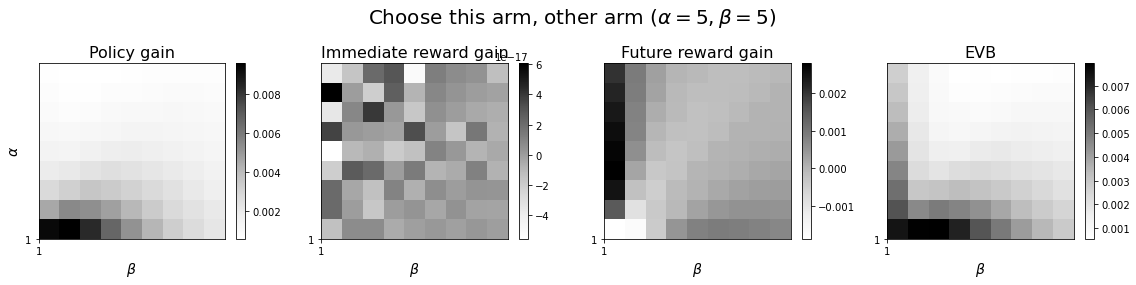

In [78]:
alphab, betab = 5, 5
plot_all(0, alphab, betab, 'Choose this arm' + ', other arm ' + r'$(\alpha=%u, \beta=%u)$'%(alphab, betab))

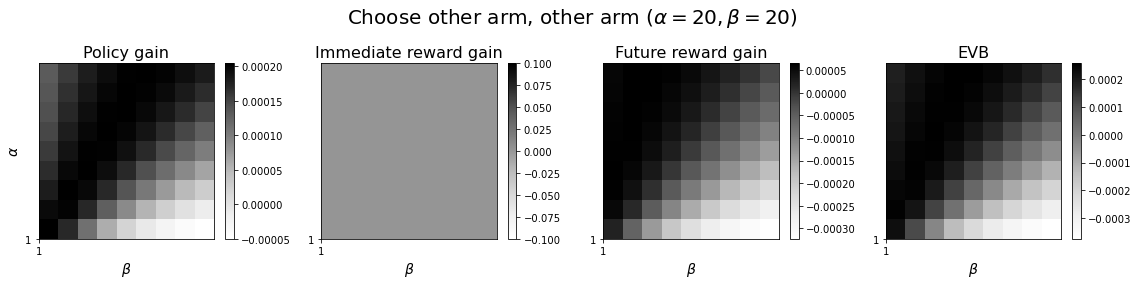

In [53]:
alphab, betab = 20, 20
plot_all(1, alphab, betab, 'Choose other arm, other arm ' + r'$(\alpha=%u, \beta=%u)$'%(alphab, betab))